In [1]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/blue_bikes_trip_data/201701-hubway-tripdata.csv', index_col=1, parse_dates=True)

path = './data/blue_bikes_trip_data/'
for file in sorted(os.listdir(path))[1:]:
    df_new = pd.read_csv(path+file, index_col=1, parse_dates=True)
    frames = [df,df_new]
    df = pd.concat(frames)


In [3]:
counts = df.groupby([pd.Grouper(freq='D'),'usertype']).count().reset_index().iloc[:, : 3]
counts.columns = ['time', 'user', 'rides']
counts = pd.pivot_table(counts,values = 'rides',index = 'time',columns='user').fillna(0)

sum_col = counts["Customer"] + counts["Subscriber"]
counts["total"] = sum_col

daily_data = counts.reset_index()
daily_data=daily_data.drop(['Customer','Subscriber'],axis=1)
daily_data.columns.name = None
daily_data

,time,total
0,2017-01-01,962.0
1,2017-01-02,1604.0
2,2017-01-03,1302.0
3,2017-01-04,3068.0
4,2017-01-05,2660.0
...,...,...
1270,2020-06-26,8493.0
1271,2020-06-27,7228.0
1272,2020-06-28,4806.0
1273,2020-06-29,4634.0


In [4]:
if 'time' in daily_data.columns:
    daily_data=daily_data.set_index('time')
    daily_data.index = daily_data.index.date

    daily_data.loc[dt.datetime.strptime('2018-03-13', '%Y-%m-%d').date()] = [0]
    daily_data.loc[dt.datetime.strptime('2019-01-20', '%Y-%m-%d').date()] = [0]
    
daily_data.sort_index(inplace=True)
daily_data.index.rename('date',inplace=True)

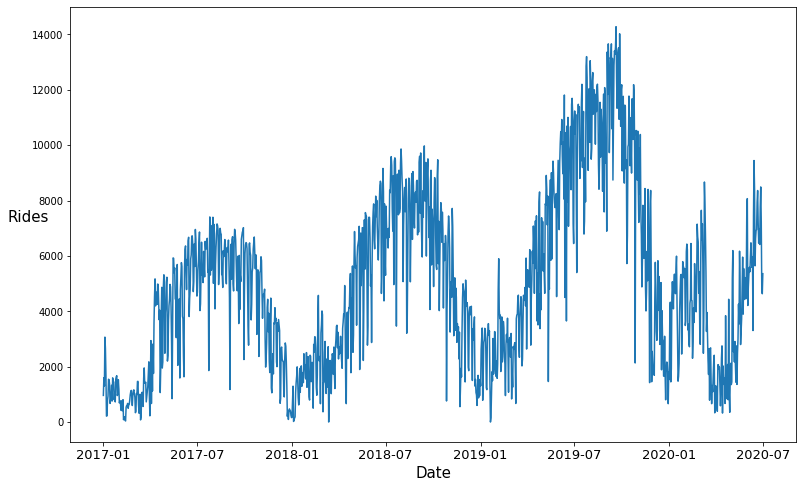

In [5]:
plt.figure(figsize=(13, 8))
plt.plot(daily_data.total)
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.show()

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Figure(432x288)
Figure(432x288)
Figure(432x288)


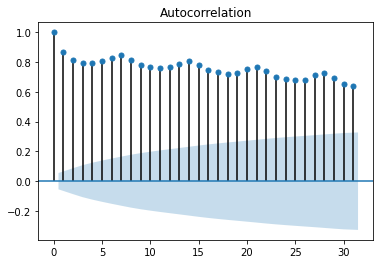

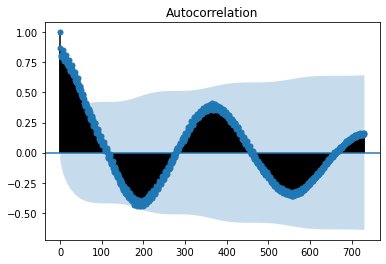

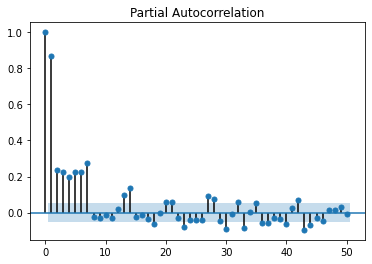

In [7]:
print(plot_acf(daily_data.total, lags=31))
print(plot_acf(daily_data.total, lags=730))
print(plot_pacf(daily_data.total, lags=50))

In [8]:
from darts import TimeSeries
from darts.models import Prophet, FFT

In [9]:
series1 = TimeSeries.from_dataframe(daily_data.reset_index(), 'date', 'total')

soe_date = '2020-03-11'
daily_data_pre_soe = daily_data.iloc[:daily_data.index.get_loc(dt.datetime.strptime(soe_date, '%Y-%m-%d').date()),:]
series2 = TimeSeries.from_dataframe(daily_data_pre_soe.reset_index(), 'date', 'total')

thru_june = '2020-06-30'
daily_data_thru_june = daily_data.iloc[:daily_data.index.get_loc(dt.datetime.strptime(thru_june, '%Y-%m-%d').date()),:]
series3 = TimeSeries.from_dataframe(daily_data_thru_june.reset_index(), 'date', 'total')
series4 = TimeSeries.from_dataframe(daily_data_thru_june.reset_index(), 'date', 'total')

In [10]:
series1 = TimeSeries.from_dataframe(daily_data.reset_index(), 'date', 'total')
train1, val1 = series1.split_before(pd.Timestamp('20200101'))

In [11]:
import time

In [12]:
start_time = time.time()

model_FFT1 = FFT()
model_FFT1.fit(train1)
prediction_FFT1 = model_FFT1.predict(len(val1))

model_Prophet1 = Prophet(daily_seasonality = True)
model_Prophet1.fit(train1)
prediction_Prophet1 = model_Prophet1.predict(len(val1))

print("--- %s seconds ---" % (time.time() - start_time))

--- 4.932375907897949 seconds ---


In [13]:
from darts.metrics import mape
from darts.metrics import ope

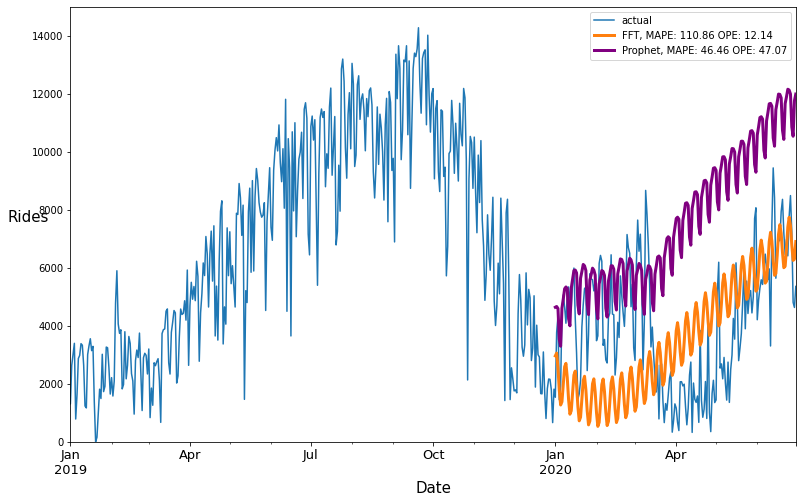

In [14]:
plt.figure(figsize=(13, 8))
series1.plot(label='actual')
prediction_FFT1.plot(label='FFT, MAPE: '+str(round(mape(prediction_FFT1, series1),2))+' OPE: '+str(round(ope(prediction_FFT1, series1),2)),lw=3)
prediction_Prophet1.plot(label='Prophet, MAPE: '+str(round(mape(prediction_Prophet1, series1),2))+' OPE: '+str(round(ope(prediction_Prophet1, series1),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2019-01-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,15000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend()
plt.show()

In [15]:
soe_date = '2020-03-11'
daily_data_pre_soe = daily_data.iloc[:daily_data.index.get_loc(dt.datetime.strptime(soe_date, '%Y-%m-%d').date()),:]
series2 = TimeSeries.from_dataframe(daily_data_pre_soe.reset_index(), 'date', 'total')
train2, val2 = series2.split_before(pd.Timestamp('20200101'))

In [16]:
model_FFT2 = FFT()
model_FFT2.fit(train2)
prediction_FFT2 = model_FFT2.predict(len(val2))

model_Prophet2 = Prophet(daily_seasonality=True)
model_Prophet2.fit(train2)
prediction_Prophet2 = model_Prophet2.predict(len(val2))

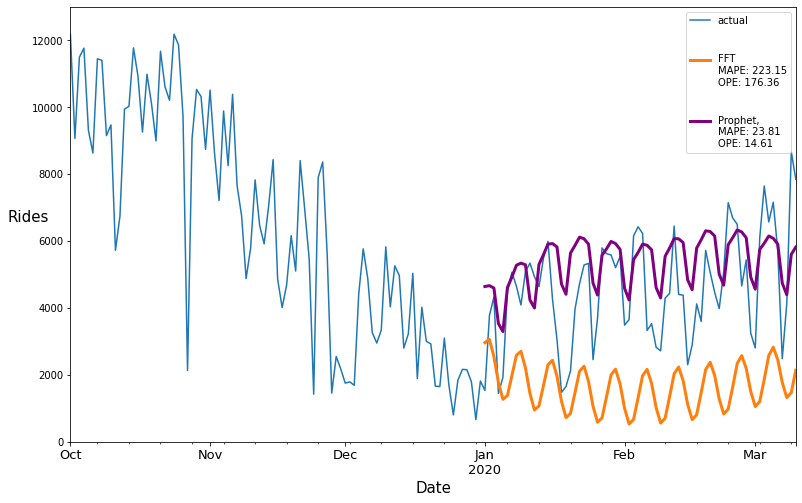

In [17]:
plt.figure(figsize=(13, 8))
series2.plot(label='actual')
prediction_FFT2.plot(label='\n\nFFT \nMAPE: '+str(round(mape(prediction_FFT2, series2),2))+'\nOPE: '+str(round(ope(prediction_FFT2, series2),2)),lw=3)
prediction_Prophet2.plot(label='\n\nProphet, \nMAPE: '+str(round(mape(prediction_Prophet2, series2),2))+'\nOPE: '+str(round(ope(prediction_Prophet2, series2),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2019-10-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-03-10', '%Y-%m-%d').date(),0,13000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.legend()
plt.show()

In [18]:
thru_june = '2020-06-30'
daily_data_thru_june = daily_data.iloc[:daily_data.index.get_loc(dt.datetime.strptime(thru_june, '%Y-%m-%d').date()),:]
series3 = TimeSeries.from_dataframe(daily_data_thru_june.reset_index(), 'date', 'total')
train3, val3 = series3.split_before(pd.Timestamp('20200501'))

In [19]:
model_FFT3 = FFT()
model_FFT3.fit(train3)
prediction_FFT3 = model_FFT3.predict(len(val3))

model_Prophet3 = Prophet(daily_seasonality=True)
model_Prophet3.fit(train3)
prediction_Prophet3 = model_Prophet3.predict(len(val3))

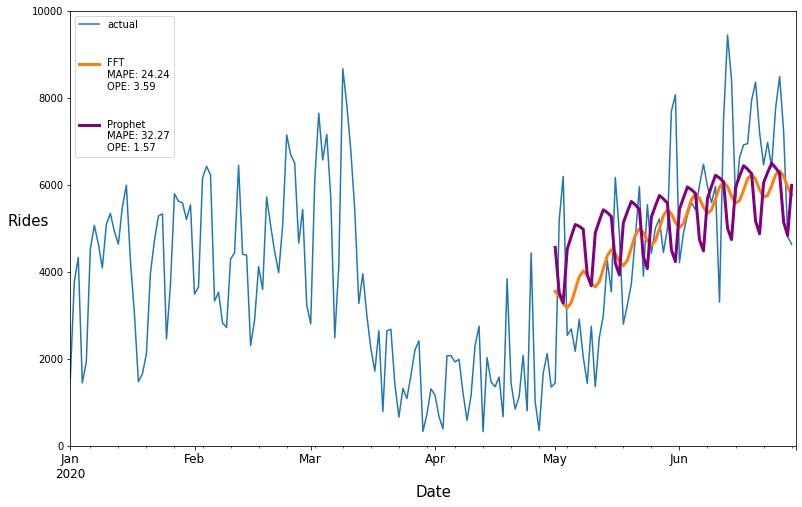

In [20]:
plt.figure(figsize=(13, 8))
series3.plot(label='actual')
prediction_FFT3.plot(label='\n\nFFT \nMAPE: '+str(round(mape(prediction_FFT3, series3),2))+'\nOPE: '+str(round(ope(prediction_FFT3, series3),2)),lw=3)
prediction_Prophet3.plot(label='\n\nProphet \nMAPE: '+str(round(mape(prediction_Prophet3, series3),2))+'\nOPE: '+str(round(ope(prediction_Prophet3, series3),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2020-01-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,10000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()

In [21]:
series4 = TimeSeries.from_dataframe(daily_data_thru_june.reset_index(), 'date', 'total')
train4, val4 = series4.split_before(pd.Timestamp('20200623'))

In [22]:
model_FFT4 = FFT()
model_FFT4.fit(train4)
prediction_FFT4 = model_FFT4.predict(len(val4))

model_Prophet4 = Prophet(changepoints=['2020-03-23'],daily_seasonality=True)
model_Prophet4.fit(train4)
prediction_Prophet4 = model_Prophet4.predict(len(val4))

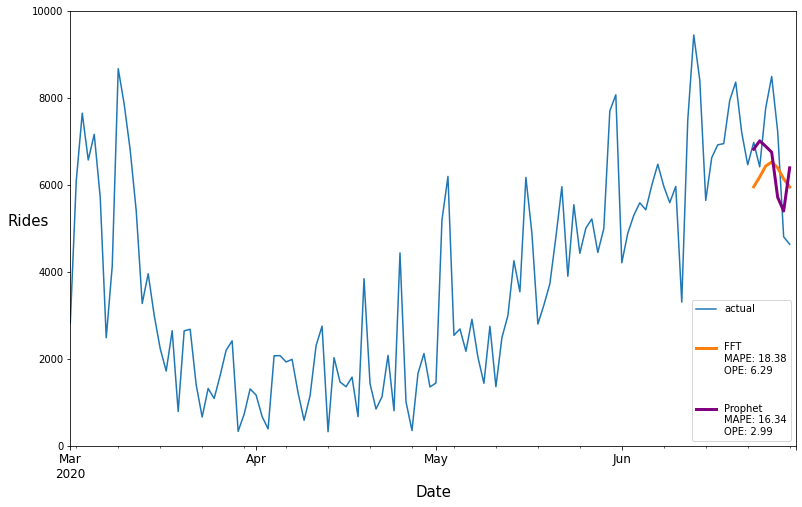

In [23]:
plt.figure(figsize=(13, 8))
series4.plot(label='actual')
prediction_FFT4.plot(label='\n\nFFT \nMAPE: '+str(round(mape(prediction_FFT4, series4),2))+'\nOPE: '+str(round(ope(prediction_FFT4, series4),2)),lw=3)
prediction_Prophet4.plot(label='\n\nProphet \nMAPE: '+str(round(mape(prediction_Prophet4, series4),2))+'\nOPE: '+str(round(ope(prediction_Prophet4, series4),2)),lw=3,color='purple')
plt.axis([dt.datetime.strptime('2020-03-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-06-30', '%Y-%m-%d').date(),0,10000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()

In [24]:
train5 = series4

In [25]:
model_FFT5 = FFT()
model_FFT5.fit(train5)
prediction_FFT5 = model_FFT5.predict(30)

model_Prophet5 = Prophet(changepoints=['2020-03-23'],daily_seasonality=True)
model_Prophet5.fit(train5)
prediction_Prophet5 = model_Prophet5.predict(30)

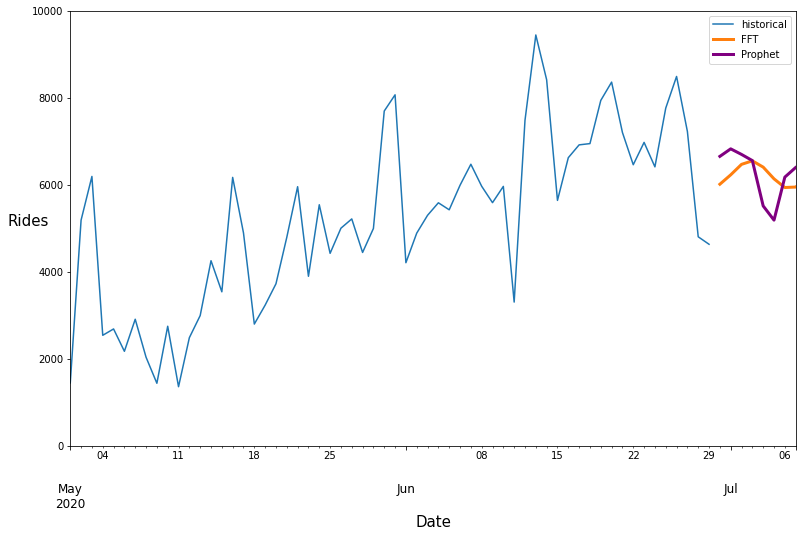

In [26]:
plt.figure(figsize=(13, 8))
series4.plot(label='historical')
prediction_FFT5.plot(label='FFT',lw=3)
prediction_Prophet5.plot(label='Prophet',lw=3,color='purple')
plt.axis([dt.datetime.strptime('2020-05-01', '%Y-%m-%d').date(),dt.datetime.strptime('2020-07-07', '%Y-%m-%d').date(),0,10000])
plt.ylabel('Rides',rotation=0,size=15)
plt.xlabel('Date',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.legend()
plt.show()